In [49]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import glob, os, re

1) Load and compute spatial average
2) Convert to Pandas DataFrame and extract time info
3) Compute monthly climatology and anomalies

In [50]:
variable = "T2MIN"
ds_obs = xr.open_dataset(f"data/OBS_subset/{variable}_subsetted_Midwest_US.nc")
regional_mean_obs = ds_obs[variable].mean(dim=['south_north', 'west_east'])
df_obs = regional_mean_obs.to_dataframe().dropna().reset_index()

df_obs.insert(1, 'month', pd.to_datetime(df_obs['time']).dt.month)
df_obs.insert(2, 'year', pd.to_datetime(df_obs['time']).dt.year)

climatology_obs = df_obs.groupby('month').agg({variable:'mean'}).reset_index()
df_obs_with_clim = df_obs.merge(climatology_obs, on='month', suffixes=('', '_clim'))
# Calculate anomalies
df_obs_with_clim[f'{variable}_anom'] = df_obs_with_clim[variable] - df_obs_with_clim[f'{variable}_clim']
df_obs_with_clim

,time,month,year,T2MIN,T2MIN_clim,T2MIN_anom
0,1980-01-31,1,1980,263.454497,263.948814,-0.494317
1,1980-02-29,2,1980,263.985808,265.609587,-1.623780
2,1980-03-31,3,1980,269.074416,271.119549,-2.045133
3,1980-04-30,4,1980,276.208306,276.428683,-0.220377
4,1980-05-31,5,1980,282.144070,282.605758,-0.461688
...,...,...,...,...,...,...
535,2024-08-31,8,2024,289.420316,289.373717,0.046599
536,2024-09-30,9,2024,285.061273,284.353702,0.707571
537,2024-10-31,10,2024,278.509554,277.285501,1.224052
538,2024-11-30,11,2024,272.444509,270.816178,1.628331


<Axes: xlabel='time'>

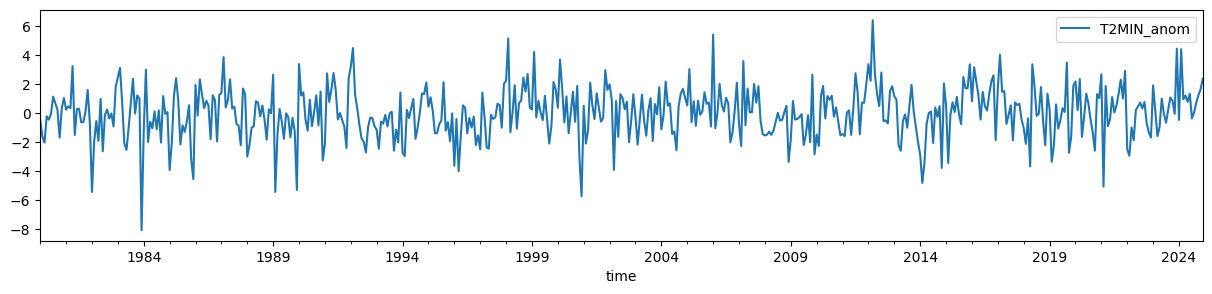

In [51]:
# check
df_obs_with_clim[['time', f'{variable}_anom']].set_index('time').plot(figsize = [15,3])

---
1) List and open SEAS5 NetCDF files for each year and month.
2) Compute spatial average.
3) Collect all time series and concatenate into a single xarray Dataset.
4) Convert to Pandas DataFrame for easier analysis and drop missing values.
5) Inspect unique years, months, and lead times to verify the dataset.

In [52]:
da.sizes["time"]

6

In [53]:
data_folder = r"data\SEAS5_subset"

seas5_files = sorted(glob.glob(os.path.join(data_folder, f"ecmwf_year-*_month-*_sfc_{variable}_subset.nc")))

years = range(1993, 2025)
months = range(1, 13)

seas5_data = []

for y in years:
    for m in months:
        fname = f"ecmwf_year-{y}_month-{m:02d}_sfc_{variable}_subset.nc"
        path = os.path.join(data_folder, fname)
        ds = xr.open_dataset(path)
        # calculate spatial average
        da = ds[variable].mean(dim=["south_north", "west_east"])

        lead = xr.DataArray(
            range(1, da.sizes["time"] + 1),
            dims="time",
            coords={"time": da["time"]}
        )

        da = da.assign_coords(year=y, init_month=m, lead=lead)
        seas5_data.append(da)

ds_seas5_all = xr.concat(seas5_data, dim="time")
df_seas5_all = ds_seas5_all.to_dataframe().dropna().reset_index()

# check 
print("years:", df_seas5_all['year'].unique())
print("months:", df_seas5_all['init_month'].unique())
print("leads:", df_seas5_all['lead'].unique())
print(df_seas5_all)

ds_seas5_all

C:\Users\Meteo\AppData\Local\Temp\ipykernel_22808\3064958762.py:27: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'number' ('number',) The recommendation is to set join explicitly for this case.
  ds_seas5_all = xr.concat(seas5_data, dim="time")
C:\Users\Meteo\AppData\Local\Temp\ipykernel_22808\3064958762.py:27: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  ds_seas5_all = xr.concat(seas5_data, dim="time")


years: [1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021 2022 2023 2024]
months: [ 1  2  3  4  5  6  7  8  9 10 11 12]
leads: [1 2 3 4 5 6]
       number       time  year  init_month  lead       T2MIN
0           0 1993-02-01  1993           1     1  263.283936
1           0 1993-03-01  1993           1     2  268.460205
2           0 1993-04-01  1993           1     3  272.553894
3           0 1993-05-01  1993           1     4  274.835510
4           0 1993-06-01  1993           1     5  284.170532
...       ...        ...   ...         ...   ...         ...
72571      50 2025-02-01  2024          12     2  261.421173
72572      50 2025-03-01  2024          12     3  268.846893
72573      50 2025-04-01  2024          12     4  270.001923
72574      50 2025-05-01  2024          12     5  278.589966
72575      50 2025-06-01  2024          12     6  286.580261

[72576 rows x 6 columns]


<xarray.DataArray 'T2MIN' (number: 51, time: 2304)> Size: 470kB
array([[263.28394, 268.4602 , 272.5539 , ..., 274.93643, 280.58273,
        284.11847],
       [261.05292, 272.39334, 270.46613, ..., 272.56696, 280.2467 ,
        284.12018],
       [265.4667 , 265.50067, 270.34033, ..., 273.83478, 277.0137 ,
        283.58005],
       ...,
       [      nan,       nan,       nan, ..., 270.91705, 276.61838,
        283.91373],
       [      nan,       nan,       nan, ..., 270.41656, 280.19675,
        284.6353 ],
       [      nan,       nan,       nan, ..., 270.00192, 278.58997,
        286.58026]], shape=(51, 2304), dtype=float32)
Coordinates:
  * number      (number) int64 408B 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49 50
  * time        (time) datetime64[ns] 18kB 1993-02-01 1993-03-01 ... 2025-06-01
    year        (time) int64 18kB 1993 1993 1993 1993 ... 2024 2024 2024 2024
    init_month  (time) int64 18kB 1 1 1 1 1 1 2 2 2 ... 11 11 12 12 12 12 12 12
    lead        (time) int64 18kB 1 2 3 4 5 6 1 2 3 4 5 ... 3 4 5 6 1 2 3 4 5 6

1) Compute climatology: calculate the mean T2MAX for each ensemble member (number), initialization month, and lead time.
2) Merge climatology: add the calculated monthly-lead climatology back into the main DataFrame.
3) Calculate anomalies: subtract the climatology from each T2MAX value to get T2MAX_anom.
4) Add month column: extract the month from the time column for easier grouping or plotting.

In [54]:
# 1) Compute climatology for each ensemble member, init_month, and lead
climatology_seas5 = (
    df_seas5_all.groupby(['number', 'init_month', 'lead'])[variable]
    .mean()
    .reset_index()
    .rename(columns={variable: f'{variable}_clim'})
)

# 2) Merge climatology back into the main df
df_seas5_with_clim = df_seas5_all.merge(
    climatology_seas5, on=['number', 'init_month', 'lead'], how='left'
)

# 3) Compute anomalies
df_seas5_with_clim[f'{variable}_anom'] = (
    df_seas5_with_clim[variable] - df_seas5_with_clim[f'{variable}_clim']
)
df_seas5_with_clim
df_seas5_with_clim.insert(3, 'month', pd.to_datetime(df_seas5_with_clim['time']).dt.month)
df_seas5_with_clim

,number,time,year,month,init_month,lead,T2MIN,T2MIN_clim,T2MIN_anom
0,0,1993-02-01,1993,2,1,1,263.283936,265.245178,-1.961243
1,0,1993-03-01,1993,3,1,2,268.460205,267.097595,1.362610
2,0,1993-04-01,1993,4,1,3,272.553894,272.252930,0.300964
3,0,1993-05-01,1993,5,1,4,274.835510,278.859650,-4.024139
4,0,1993-06-01,1993,6,1,5,284.170532,284.483154,-0.312622
...,...,...,...,...,...,...,...,...,...
72571,50,2025-02-01,2024,2,12,2,261.421173,263.867371,-2.446198
72572,50,2025-03-01,2024,3,12,3,268.846893,269.294220,-0.447327
72573,50,2025-04-01,2024,4,12,4,270.001923,272.203796,-2.201874
72574,50,2025-05-01,2024,5,12,5,278.589966,278.867645,-0.277679


In [55]:
# check 
df_plt = df_seas5_with_clim.query("number == 0 and lead == 1")[['time', 'year', 'month', f'{variable}_anom']].sort_values('time')
df1 = pd.merge(df_plt, df_obs_with_clim[['year', 'month', f'{variable}_anom']], on=['year', 'month'], how='left', suffixes=('_sim', '_obs'))
df1

,time,year,month,T2MIN_anom_sim,T2MIN_anom_obs
0,1993-02-01,1993,2,-1.961243,-2.462022
1,1993-03-01,1993,3,-2.461975,-0.592037
2,1993-04-01,1993,4,-0.082458,-0.726577
3,1993-05-01,1993,5,-2.680847,-0.131091
4,1993-06-01,1993,6,1.998199,-0.920616
...,...,...,...,...,...
379,2024-09-01,2024,9,1.132050,0.707571
380,2024-10-01,2024,10,-0.451660,1.224052
381,2024-11-01,2024,11,3.226440,1.628331
382,2024-12-01,2024,12,1.475067,2.361077


<Axes: xlabel='time'>

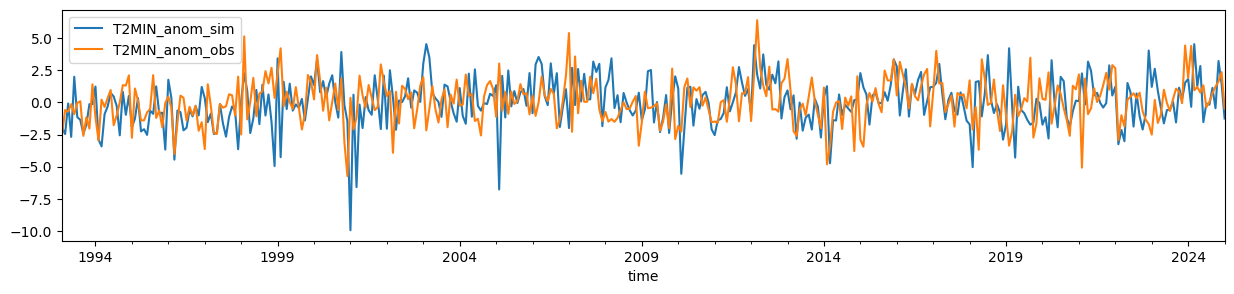

In [56]:
# check
df1.set_index('time')[[f'{variable}_anom_sim', f'{variable}_anom_obs']].plot(figsize = [15,3])

In [57]:
# Merge obs with model on 'time'
cols_sim = ['time', 'year', 'month', 'init_month', 'number', 'lead', f'{variable}_anom']
cols_obs = ['year', 'month', f'{variable}_anom']
df_merged = pd.merge(
    df_seas5_with_clim[cols_sim],
    df_obs_with_clim[cols_obs],
    on=['year', 'month'],
    suffixes=('_sim', '_obs')
)
df_merged.sort_values(['time', 'number'])


,time,year,month,init_month,number,lead,T2MIN_anom_sim,T2MIN_anom_obs
0,1993-02-01,1993,2,1,0,1,-1.961243,-2.462022
2304,1993-02-01,1993,2,1,1,1,-3.935516,-2.462022
4608,1993-02-01,1993,2,1,2,1,-0.631805,-2.462022
6912,1993-02-01,1993,2,1,3,1,-4.798126,-2.462022
9216,1993-02-01,1993,2,1,4,1,-5.088745,-2.462022
...,...,...,...,...,...,...,...,...
70271,2025-06-01,2024,6,12,46,6,-1.416687,1.331034
70847,2025-06-01,2024,6,12,47,6,0.315460,1.331034
71423,2025-06-01,2024,6,12,48,6,-1.428650,1.331034
71999,2025-06-01,2024,6,12,49,6,-0.045654,1.331034


In [63]:
# Compute correlation of anomalies per ensemble/init_month/lead
df_anom_corr = (
    df_merged.groupby(['number', 'init_month', 'lead'])
    .apply(lambda g: g[f'{variable}_anom_sim'].corr(g[f'{variable}_anom_obs']), include_groups=False)
    .reset_index(name='anom_corr')
)
df_anom_corr.to_csv(f"output/anomaly_corr_{variable}.csv", index=False)
df_anom_corr

,number,init_month,lead,anom_corr
0,0,1,1,-0.058960
1,0,1,2,0.305776
2,0,1,3,0.207785
3,0,1,4,0.160173
4,0,1,5,0.265692
...,...,...,...,...
3667,50,12,2,-0.172693
3668,50,12,3,0.753120
3669,50,12,4,0.312494
3670,50,12,5,-0.675405


<Axes: >

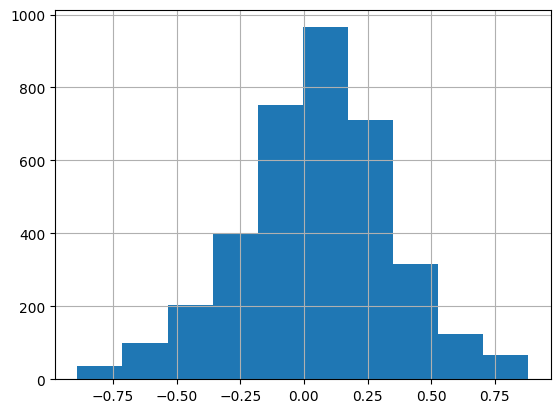

In [67]:
# check
df_anom_corr['anom_corr'].hist()

In [66]:
# Compute percentiles across ensemble members for each lead
percentiles = [33, 50, 66]
pct = df_anom_corr.groupby(['init_month', 'lead'])['anom_corr'].quantile([p/100 for p in percentiles]).unstack()
pct.columns = [f"p{p}" for p in percentiles]
summary_df = pct.reset_index()
summary_df.to_csv(f"output/summary_{variable}.csv", index=False)
summary_df

,init_month,lead,p33,p50,p66
0,1,1,-0.069430,0.024475,0.138100
1,1,2,-0.047726,0.050489,0.192386
2,1,3,-0.063299,0.033153,0.088533
3,1,4,-0.020790,0.096086,0.198382
4,1,5,0.009901,0.090512,0.198591
...,...,...,...,...,...
67,12,2,-0.162224,-0.040712,0.124730
68,12,3,-0.031864,0.117767,0.167573
69,12,4,-0.117032,0.038529,0.134185
70,12,5,-0.109607,0.011520,0.098086


In [60]:
# Merge percentiles back into the original dataframe
df_classified = df_anom_corr.merge(summary_df, on=['init_month', 'lead'], how='left')

# Create an empty column for category
df_classified['category'] = ""

# Loop over each row and assign category
for i, row in df_classified.iterrows():
    if row['anom_corr'] < row['p33']:
        df_classified.at[i, 'category'] = 'problematic'
    elif row['anom_corr'] < row['p66']:
        df_classified.at[i, 'category'] = 'acceptable'
    else:
        df_classified.at[i, 'category'] = 'good'

df_classified.to_csv(f"output/classified_{variable}.csv", index=False)
df_classified

,number,init_month,lead,anom_corr,p33,p50,p66,category
0,0,1,1,-0.058960,-0.069430,0.024475,0.138100,acceptable
1,0,1,2,0.305776,-0.047726,0.050489,0.192386,good
2,0,1,3,0.207785,-0.063299,0.033153,0.088533,good
3,0,1,4,0.160173,-0.020790,0.096086,0.198382,acceptable
4,0,1,5,0.265692,0.009901,0.090512,0.198591,good
...,...,...,...,...,...,...,...,...
3667,50,12,2,-0.172693,-0.162224,-0.040712,0.124730,problematic
3668,50,12,3,0.753120,-0.031864,0.117767,0.167573,good
3669,50,12,4,0.312494,-0.117032,0.038529,0.134185,good
3670,50,12,5,-0.675405,-0.109607,0.011520,0.098086,problematic
